In [1]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [6]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain

from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression


from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier





### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br />
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

#### Plot examplar encoding matrix:

(-0.5, 7816.5, 2741.5, -0.5)

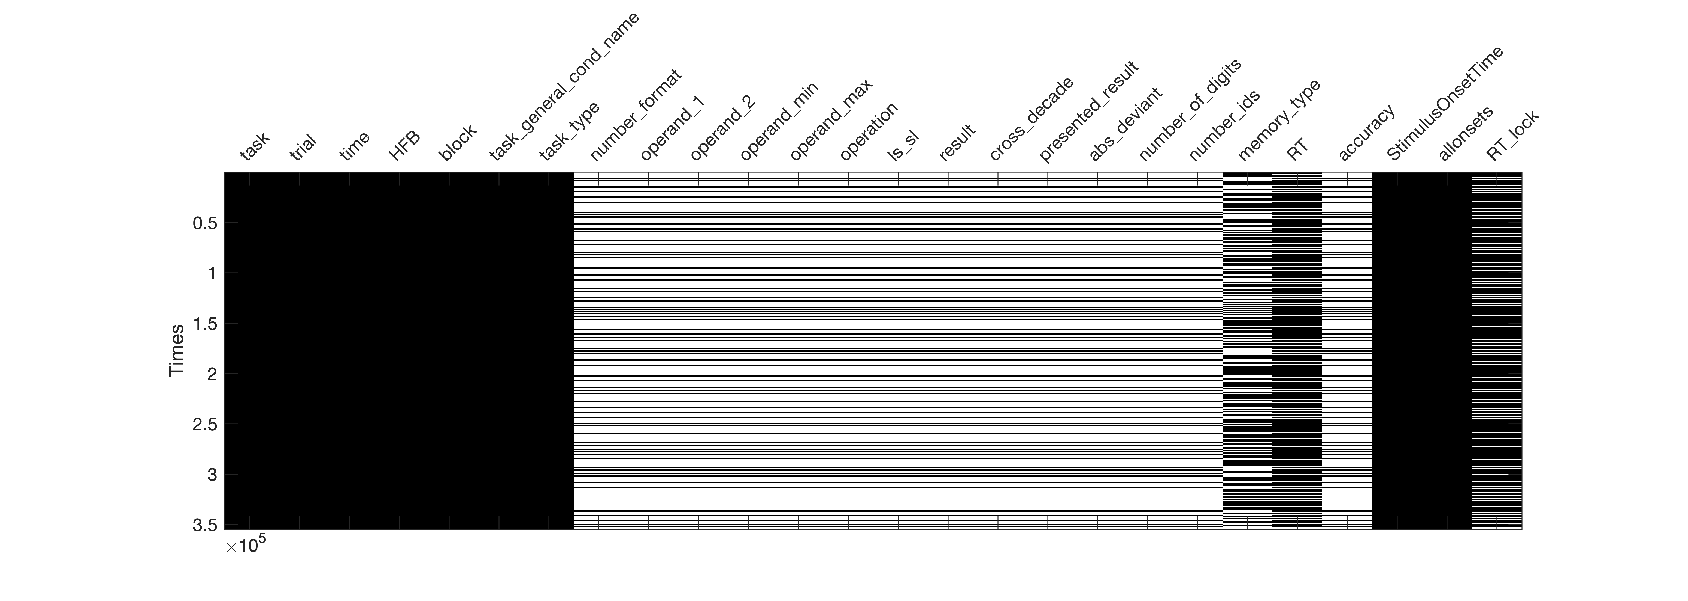

In [156]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/figures/encoding_matrix.png') 
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(im)
plt.axis('off')

### Load the data



In [157]:
#data = np.genfromtxt('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data.csv', delimiter=',')
data = pd.read_csv('/Users/pinheirochagas/Pedro/drive/Stanford/projects/math_network/encoding_model/data_61.csv') 


In [158]:
# Set extreme values to zero
data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0

# Recode task name
data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 3
data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1
data.loc[data.loc[:,'task_general_cond_name']==8, 'task_general_cond_name'] = 2

### Plot all blocks concatenated

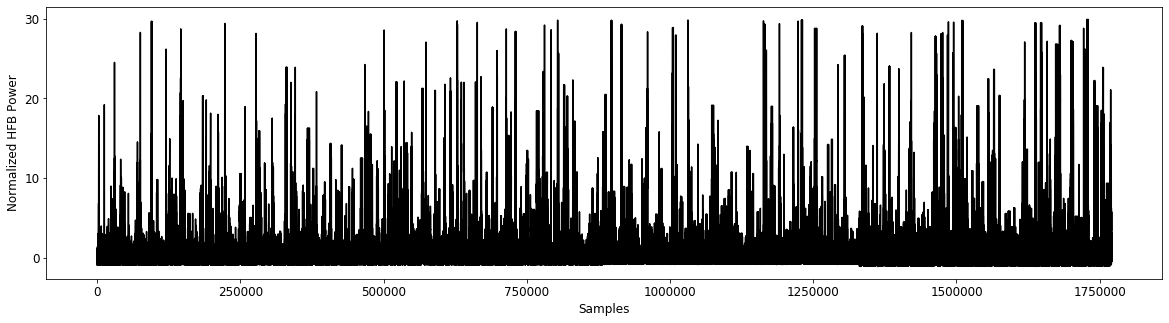

In [159]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data.loc[:,'HFB'], color='k')
plt.xlabel('Samples')
plt.ylabel('Normalized HFB Power')
plt.rcParams.update({'font.size': 20})

### Plot blocks saparated

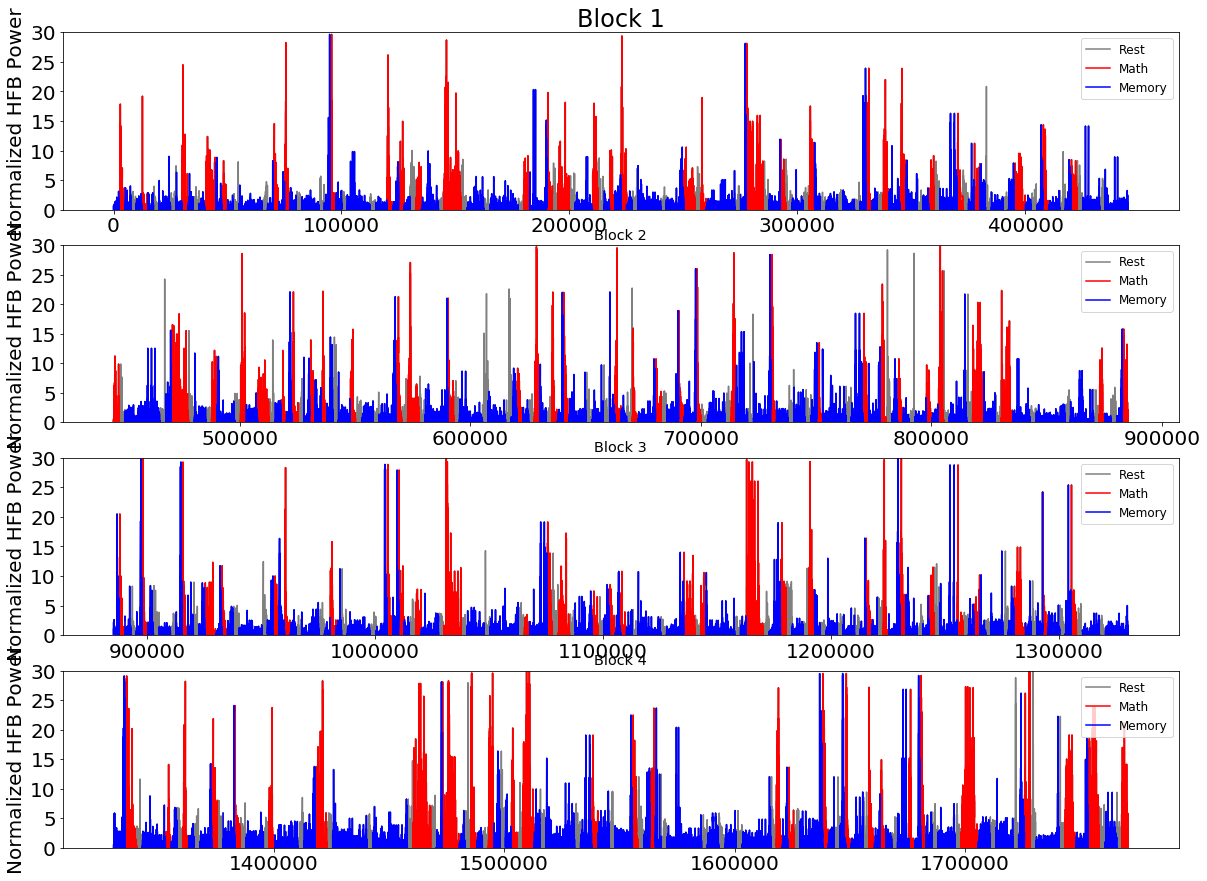

In [160]:
n_blocks = np.int(np.max(data.loc[:,'block']))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
math_trials = data.loc[:,'HFB'].copy()
math_trials[data.loc[:,'task_general_cond_name']!=3] = np.nan
memo_trials = data.loc[:,'HFB'].copy()
memo_trials[data.loc[:,'task_general_cond_name']!=1] = np.nan

for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(data.loc[data.loc[:,'block']==i+1,'HFB'], color=[0.5,0.5,0.5], label="Rest")
    ax[i].plot(math_trials[data.loc[:,'block']==i+1], 'r', label="Math")
    ax[i].plot(memo_trials[data.loc[:,'block']==i+1], 'b', label="Memory")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    #ax[i].set_xlabel('Samples')
    ax[i].set_ylabel('Normalized HFB Power')
    plt.rcParams.update({'font.size': 12}) 
    ax[i].legend()


In [161]:
features = np.array(data.loc[:,'task_general_cond_name'])
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

In [162]:
features_reshape = np.reshape(features, (trials, times))
np.shape(features_reshape)
features_reshape = np.expand_dims(features_reshape, axis=1)
np.shape(features_reshape)

(708, 1, 2501)

In [163]:
delays = np.linspace(-2, 0., 100)
X_delayed = delay_time_series(features_reshape, delays, 500)

In [164]:
np.shape(X_delayed)

(708, 1, 100, 2501)

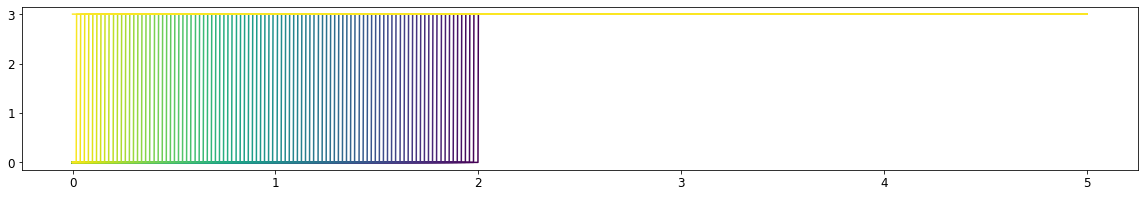

In [165]:
fig, ax = plt.subplots(figsize=(20, 3))
colors = plt.cm.viridis(np.linspace(0,1,100))

for i in range(100):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax.plot(np.unique(data.loc[:,'time']), np.squeeze(X_delayed[1,0,i,:]), color=colors[i])

Text(0.5, 1.0, 'Time-Delayed Task Name')

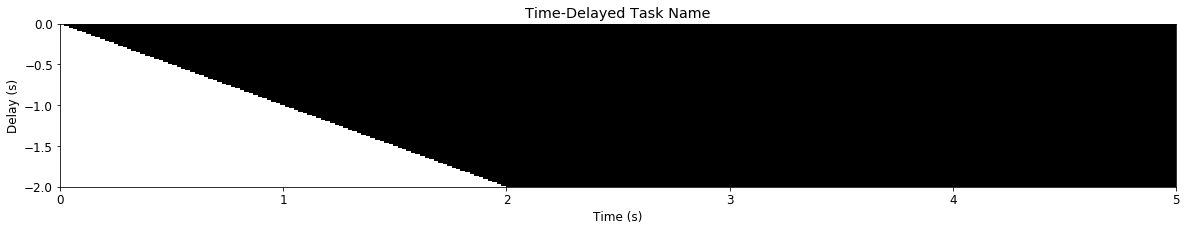

In [166]:
times = np.unique(data.loc[:,'time'])
fig, ax = plt.subplots(figsize=(20, 3))
ax.pcolormesh(times, delays,
              X_delayed[1,0,:,:], cmap='binary')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Task Name')

In [167]:
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

In [168]:
# Define the dependent variable
y = np.array(data.loc[:,'HFB']) # HFB

In [169]:
# Fit the model
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_env, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

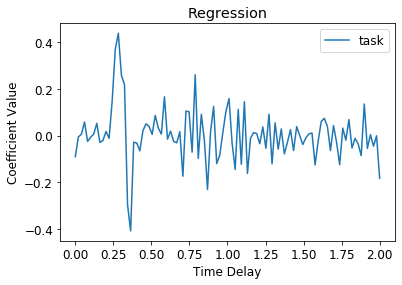

In [96]:
# Plot results
fig, ax = plt.subplots()
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'task')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [62]:
delays

array([-4.        , -3.78947368, -3.57894737, -3.36842105, -3.15789474,
       -2.94736842, -2.73684211, -2.52631579, -2.31578947, -2.10526316,
       -1.89473684, -1.68421053, -1.47368421, -1.26315789, -1.05263158,
       -0.84210526, -0.63157895, -0.42105263, -0.21052632,  0.        ])

In [170]:
# Choose another feature
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
features = np.array(data.loc[:,'result'])

features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)
X_delayed = delay_time_series(features_reshape, delays, 500)
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

est_res = make_pipeline(StandardScaler(), LinearRegression())
est_res.fit(X_env, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

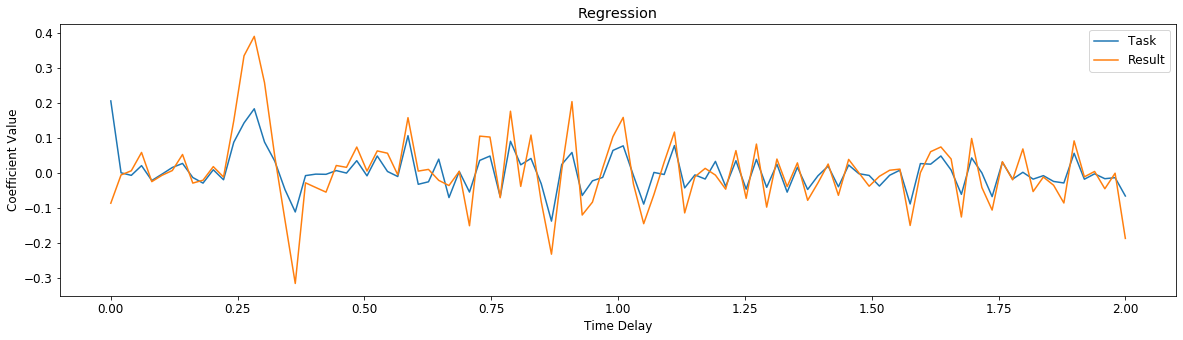

In [171]:
# Plot results
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'Task')
ax.plot(np.abs(delays), est_res.steps[-1][-1].coef_,label = 'Result')
#ax.plot(np.abs(delays), est_cd.steps[-1][-1].coef_,label = 'Cross decade')
#ax.plot(np.abs(delays), est_task.steps[-1][-1].coef_,label = 'Task')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [337]:
features

array([0., 0., 0., ..., 1., 1., 1.])

In [108]:
X_env

array([[0., 0., 0., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 6.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]])

In [172]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.collections as clt


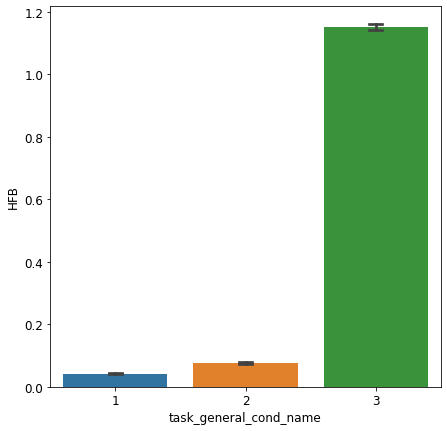

In [173]:
f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x = "task_general_cond_name", y = "HFB", data = data, capsize= .1)


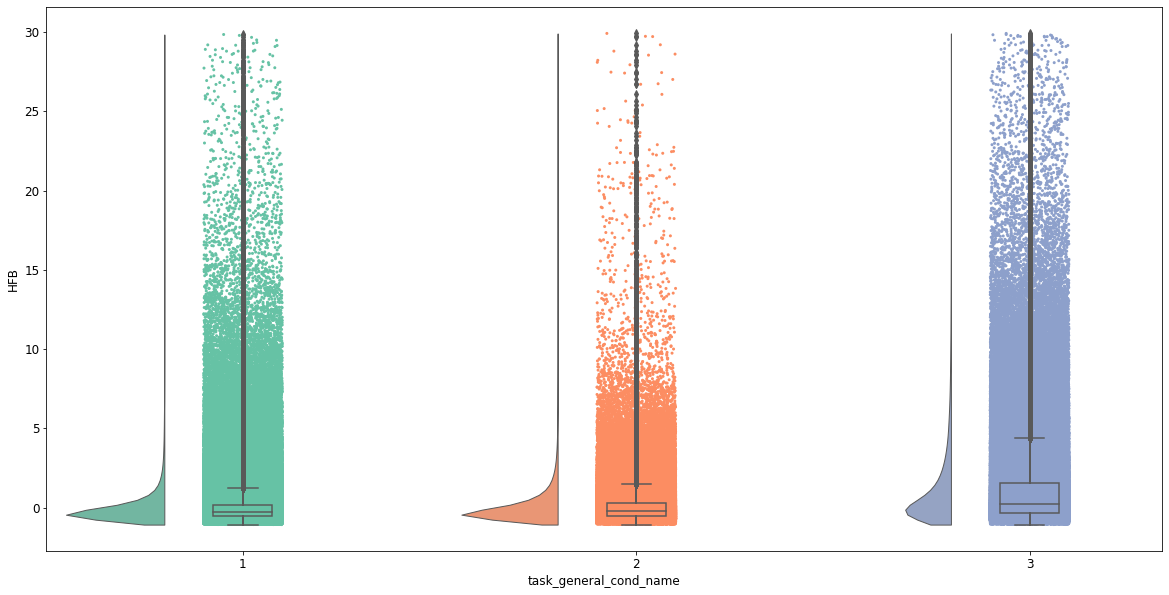

In [176]:
dx="task_general_cond_name"; dy="HFB"; ort="v"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(20, 10))

ax=pt.RainCloud(x = dx, y = dy, data = data, palette = pal, bw = sigma,
                 width_viol = .5, ax = ax, orient = ort)

In [131]:
import ptitprince as pt
